In [2]:
import pandas
import numpy as np

df = pandas.read_csv("meta_scan_csvs/test_trace.csv")
# drop ts column, not useful
df = df.drop('ts', axis=1)
df

,value,counter_name,t_s
0,5.450175e+08,Clocks / Second,0.000000
1,1.152707e+01,GPU % Bus Busy,0.000006
2,1.487638e+00,% Vertex Fetch Stall,0.000009
3,8.857108e+00,% Texture Fetch Stall,0.000011
4,2.388758e-01,L1 Texture Cache Miss Per Pixel,0.000014
...,...,...,...
30156,0.000000e+00,% Time Compute,25.177647
30157,4.950788e+01,% Nearest Filtered,25.177648
30158,5.049212e+01,% Linear Filtered,25.177649
30159,0.000000e+00,% Anisotropic Filtered,25.177650


In [25]:
# STEP 1: restructure data frame before any data analysis/visualization

# STEP 1a: because time signatures are stored down to the microsecond, we don't have values for multiple features at any time signature
# bin/round first to reduce sparsity and memory usage; need to round time signature to a less precise value, but how many decimal places?
# calculate mean time gap
np.diff(df.sort_values("t_s")["t_s"].unique()).mean()

0.0008348027588196286

In [15]:
# mean time gap between samples is ≈ 0.0008348 seconds, round to the nearest millisecond (3 places)
# update: tried rounding to 3 places, but data was too sparse, switching to 2 places
df["Time (s)"] = df["t_s"].round(2)

# STEP 1b: columns should be feature names, currently all features are lumped as rows under counter_name
features_df = (df.pivot_table(
            index="Time (s)",
            columns="counter_name",
            values="value",
            aggfunc="mean", # if multiple rows have same counter_name and time bin, mean value is used
            observed=True)
          .sort_index())
features_df = features_df.reset_index()
features_df.columns.name = None
features_df.head()

,Time (s),% Anisotropic Filtered,% Linear Filtered,% Nearest Filtered,% Non-Base Level Textures,% Prims Clipped,% Prims Trivially Rejected,% Shader ALU Capacity Utilized,% Shaders Busy,% Stalled on System Memory,...,display_refresh_rate,gpu_frequency_mhz,gpu_level,gpu_util,guardian_gpu_ms,last_used_foveation_level,mem_frequency_mhz,screen_tears_per_second,stale_frames_per_second,timewarp_gpu_ms
0,0.00,0.0,54.632042,46.249762,0.634165,1.629208,52.051775,66.524354,61.792019,0.225772,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0.01,0.0,16.071980,5.934527,2.167027,0.736205,9.231997,13.078817,13.468463,0.005057,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0.02,0.0,32.814489,17.957354,1.827099,0.925887,34.362786,34.978084,36.697215,0.107091,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0.03,0.0,24.899863,17.957280,0.000000,0.946458,20.014954,29.945714,32.626293,0.038149,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0.04,0.0,15.949703,6.257203,1.817604,0.425622,20.934389,15.137483,14.188897,0.047397,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [82]:
# STEP 1c: fix sparsity
# NaNs are the result of some features only being recorded every second or so, rather than every ms
# forward fill for each feature, then backward fill so beginning rows aren't NaNs
features_df = features_df.replace(0, np.nan)
features_df = features_df.dropna(axis=1, how='all')
features_df = features_df.ffill()
features_df = features_df.bfill()
features_df = features_df.dropna(axis=1, how='any')
features_df

,Time (s),% Linear Filtered,% Nearest Filtered,% Non-Base Level Textures,% Prims Clipped,% Prims Trivially Rejected,% Shader ALU Capacity Utilized,% Shaders Busy,% Stalled on System Memory,% Texture Fetch Stall,...,cpu_util_4,cpu_util_5,display_refresh_rate,gpu_frequency_mhz,gpu_level,gpu_util,mem_frequency_mhz,screen_tears_per_second,stale_frames_per_second,timewarp_gpu_ms
0,0.01,54.632042,46.249762,0.634165,1.629208,52.051775,66.524354,61.792019,0.225772,20.049740,...,24.0,26.0,72.0,545.0,2.0,26.251325,3196.0,1.0,17.0,2.210866
1,0.01,16.071980,5.934527,2.167027,0.736205,9.231997,13.078817,13.468463,0.005057,4.732560,...,24.0,26.0,72.0,545.0,2.0,26.251325,3196.0,1.0,17.0,2.210866
2,0.02,32.814489,17.957354,1.827099,0.925887,34.362786,34.978084,36.697215,0.107091,11.188982,...,24.0,26.0,72.0,545.0,2.0,26.251325,3196.0,1.0,17.0,2.210866
3,0.03,24.899863,17.957280,1.827099,0.946458,20.014954,29.945714,32.626293,0.038149,11.078970,...,24.0,26.0,72.0,545.0,2.0,26.251325,3196.0,1.0,17.0,2.210866
4,0.04,15.949703,6.257203,1.817604,0.425622,20.934389,15.137483,14.188897,0.047397,3.561017,...,24.0,26.0,72.0,545.0,2.0,26.251325,3196.0,1.0,17.0,2.210866
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
391,24.83,50.449116,49.512093,15.955950,0.010793,70.144836,6.224728,12.045204,0.052006,6.846641,...,32.0,30.0,72.0,456.0,2.0,78.001791,2092.0,1.0,73.0,2.165440
392,24.88,50.436279,49.563721,15.955950,0.010793,70.144836,6.224728,12.045204,0.052006,7.112385,...,32.0,30.0,72.0,456.0,2.0,78.001791,2092.0,1.0,73.0,2.165440
393,24.98,50.468212,49.531788,15.955950,0.010793,70.144836,6.224728,12.045204,0.052006,6.866071,...,32.0,30.0,72.0,456.0,2.0,78.001791,2092.0,1.0,73.0,2.165440
394,25.08,50.421314,49.578686,15.955950,0.010793,70.144836,6.224728,12.045204,0.052006,7.639123,...,32.0,30.0,72.0,456.0,2.0,78.001791,2092.0,1.0,73.0,2.165440


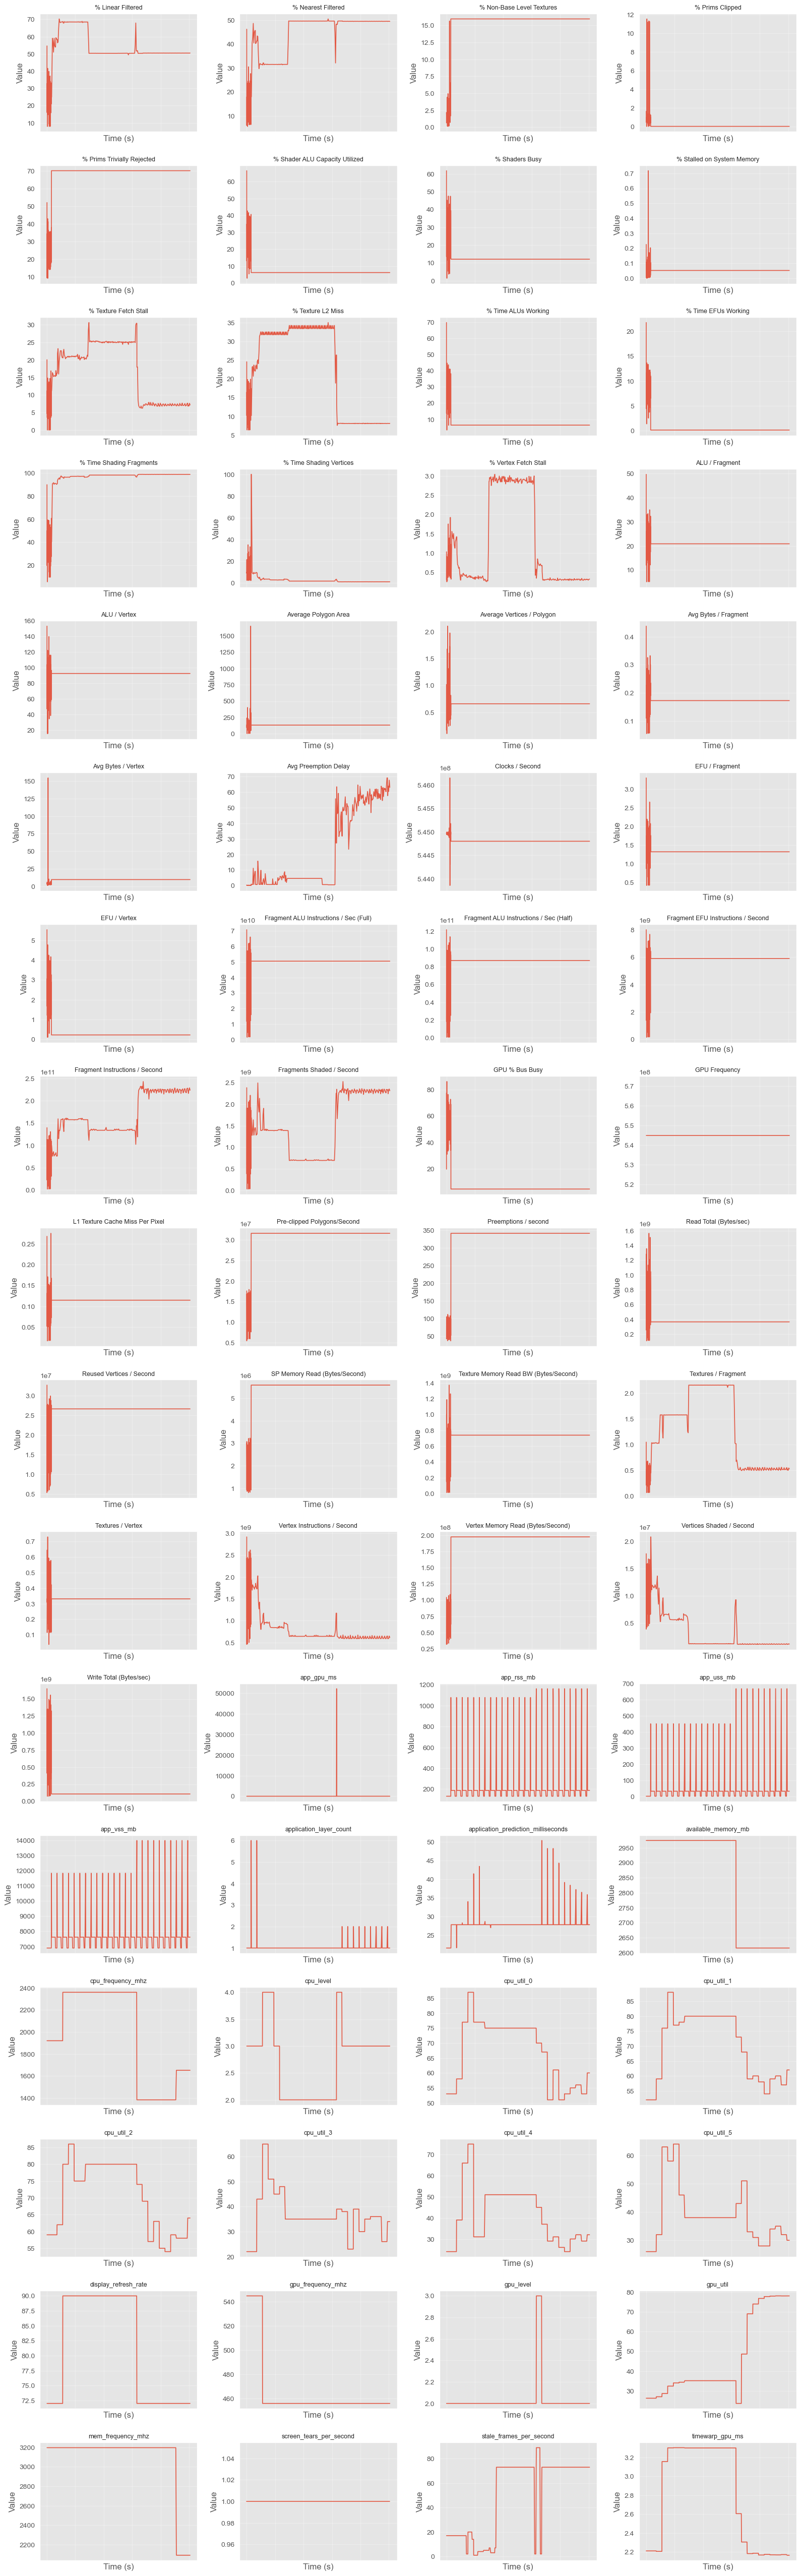

In [84]:
import matplotlib.pyplot as plt
import math

plt.style.use('ggplot')

ncols = 4
nrows = math.ceil(len(features_df.columns) / ncols)

fig, axes = plt.subplots(
    nrows=nrows, 
    ncols=ncols, 
    figsize=(16, 54),
    sharex=True
)

axes = axes.flatten()

for i, col in enumerate(features_df.columns[1:]):
    ax = axes[i]
    ax.plot(features_df["Time (s)"], features_df[col], linewidth=1.2, alpha=0.9)
    ax.set_title(col, fontsize=9)
    ax.set_xlabel("Time (s)")
    ax.set_ylabel("Value")
    ax.grid(True, alpha=0.3)

for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

In [88]:
# normalize and fill again
norm = features_df.set_index("Time (s)")
norm = (norm - norm.mean())/norm.std()
norm = norm.dropna(axis=1, how='any')
norm = norm.ffill()
norm = norm.bfill()
norm

,% Linear Filtered,% Nearest Filtered,% Non-Base Level Textures,% Prims Clipped,% Prims Trivially Rejected,% Shader ALU Capacity Utilized,% Shaders Busy,% Stalled on System Memory,% Texture Fetch Stall,% Texture L2 Miss,...,cpu_util_3,cpu_util_4,cpu_util_5,display_refresh_rate,gpu_frequency_mhz,gpu_level,gpu_util,mem_frequency_mhz,stale_frames_per_second,timewarp_gpu_ms
Time (s),,,,,,,,,,,,,,,,,,,,,
0.01,0.429008,0.494446,-2.305266,1.027640,-0.486980,5.782421,5.670130,4.332356,0.607613,0.354611,...,-1.223044,-1.010536,-1.002896,-0.835347,1.673500,-0.176553,-0.843034,0.306081,-0.908551,-0.844084
0.01,-2.368291,-2.408902,-2.026166,0.336940,-2.798393,0.261832,-0.225225,-1.253345,-1.280256,-0.898665,...,-1.223044,-1.010536,-1.002896,-0.835347,1.673500,-0.176553,-0.843034,0.306081,-0.908551,-0.844084
0.02,-1.153723,-1.543064,-2.088060,0.483650,-1.441832,2.523889,2.608626,1.328876,-0.484491,-0.350464,...,-1.223044,-1.010536,-1.002896,-0.835347,1.673500,-0.176553,-0.843034,0.306081,-0.908551,-0.844084
0.03,-1.727882,-1.543069,-2.088060,0.499561,-2.216328,2.004077,2.111983,-0.415874,-0.498050,-0.887861,...,-1.223044,-1.010536,-1.002896,-0.835347,1.673500,-0.176553,-0.843034,0.306081,-0.908551,-0.844084
0.04,-2.377161,-2.385664,-2.089788,0.096717,-2.166697,0.474479,-0.137334,-0.181828,-1.424650,-0.962649,...,-1.223044,-1.010536,-1.002896,-0.835347,1.673500,-0.176553,-0.843034,0.306081,-0.908551,-0.844084
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24.83,0.125562,0.729386,0.484485,-0.224136,0.489684,-0.446152,-0.398859,-0.065191,-1.019692,-1.080252,...,-0.002568,-0.433087,-0.621208,-0.835347,-0.596041,-0.176553,1.729128,-3.258861,0.909699,-0.929432
24.88,0.124631,0.733105,0.484485,-0.224136,0.489684,-0.446152,-0.398859,-0.065191,-0.986938,-1.081403,...,-0.002568,-0.433087,-0.621208,-0.835347,-0.596041,-0.176553,1.729128,-3.258861,0.909699,-0.929432
24.98,0.126947,0.730805,0.484485,-0.224136,0.489684,-0.446152,-0.398859,-0.065191,-1.017297,-1.080031,...,-0.002568,-0.433087,-0.621208,-0.835347,-0.596041,-0.176553,1.729128,-3.258861,0.909699,-0.929432


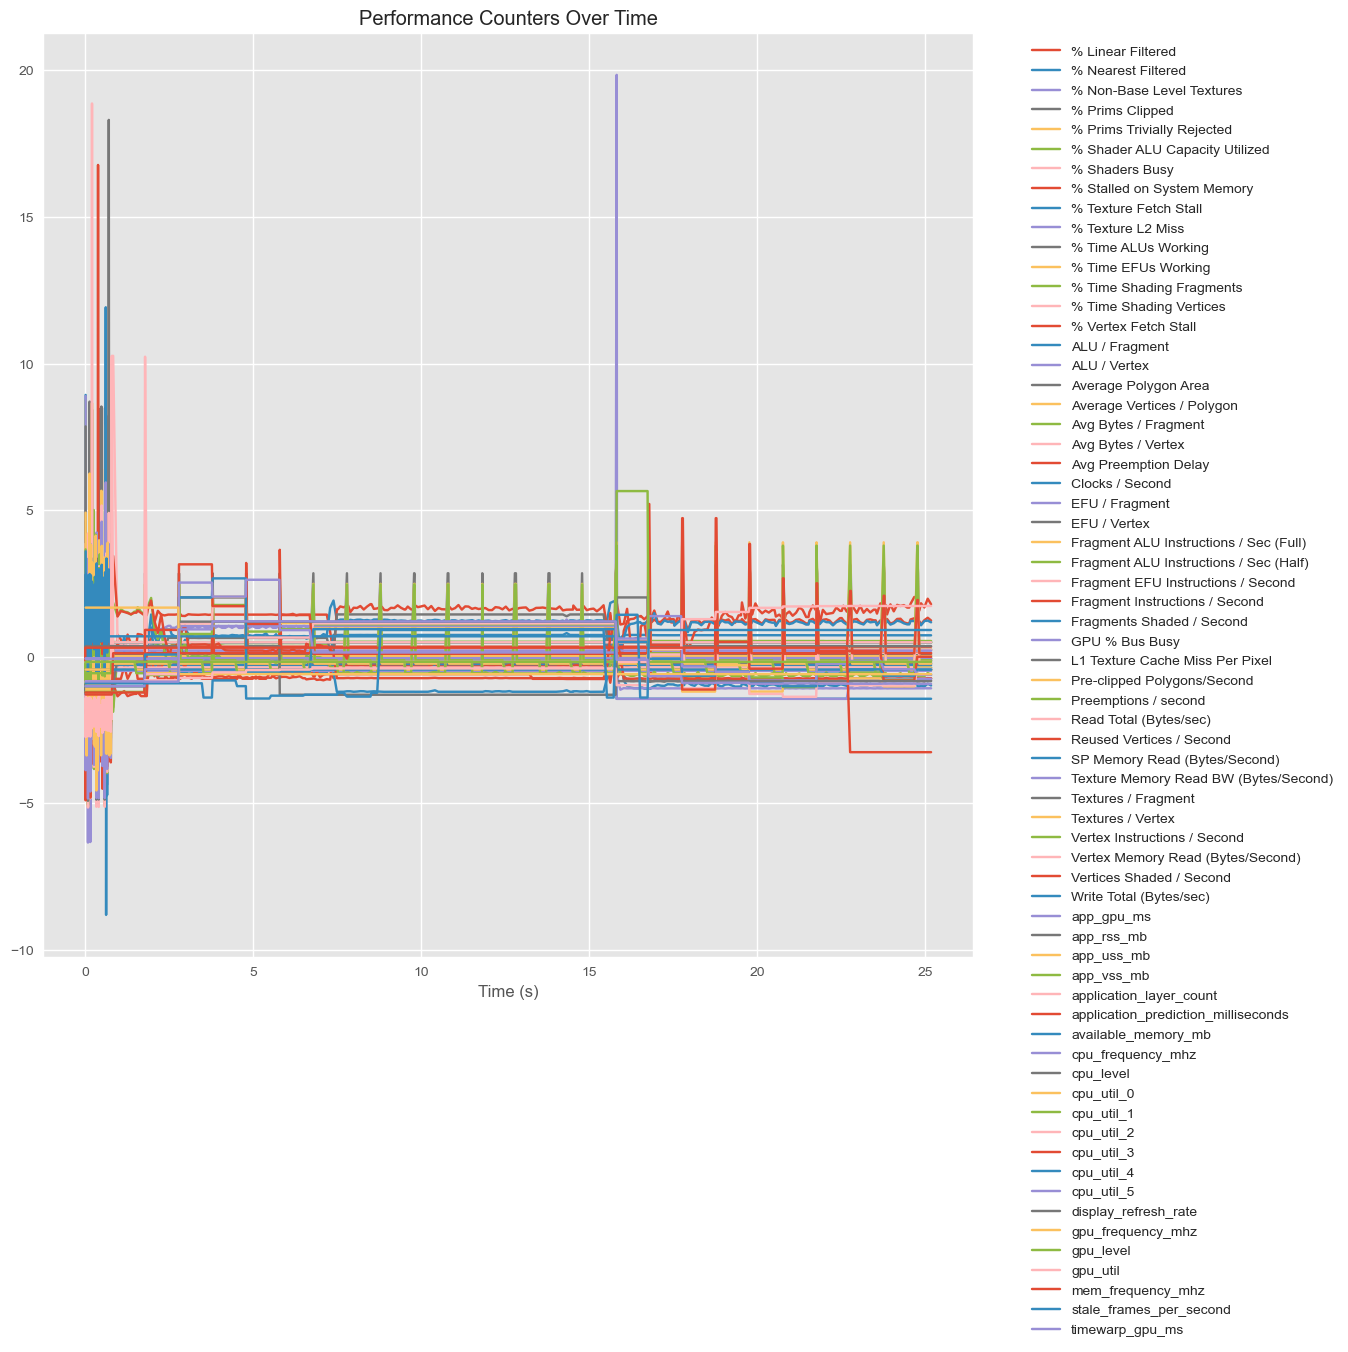

In [92]:
# plot on the same graph
axes2 = norm.plot(figsize=(12,12), title="Performance Counters Over Time")
axes2.legend(bbox_to_anchor=(1.05, 1), loc='upper left')